# 变换 v2：端到端的目标检测/分割示例

目标检测和分割任务得到了原生支持：{mod}`torchvision.transforms.v2` 使得图像、视频、边界框和掩码可以联合变换。

本示例展示了使用 {mod}`torchvision.datasets`、{mod}`torchvision.models` 和 {mod}`torchvision.transforms.v2` 的 Torchvision 工具进行端到端实例分割训练的案例。这里涵盖的所有内容都可以类似地应用于目标检测或语义分割任务。

In [1]:
import pathlib

import torch
import torch.utils.data

from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2

torch.manual_seed(0)

# This loads fake data for illustration purposes of this example. In practice, you'll have
# to replace this with the proper data.
# If you're trying to run that on Colab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
ROOT = pathlib.Path("../../images") 
IMAGES_PATH = str(ROOT)
ANNOTATIONS_PATH = str(ROOT/"coco_instances.json")
from helpers import plot

## 数据集准备

首先加载 {class}`~torchvision.datasets.CocoDetection` 数据集，以便查看它目前返回的内容。

In [2]:
dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH)

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{type(target[0]) = }\n{target[0].keys() = }")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
type(img) = <class 'PIL.Image.Image'>
type(target) = <class 'list'>
type(target[0]) = <class 'dict'>
target[0].keys() = dict_keys(['segmentation', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])


Torchvision 数据集保留了数据集作者所设定的数据结构和类型。因此，默认情况下，输出结构可能并不总是与模型或变换兼容。

为了克服这一点，可以使用 {func}`~torchvision.datasets.wrap_dataset_for_transforms_v2` 函数。对于 {class}`~torchvision.datasets.CocoDetection`，这会将目标结构更改为单个字典列表：

In [3]:
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=("boxes", "labels", "masks"))

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }\n{type(target['masks']) = }")

type(img) = <class 'PIL.Image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'masks', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>
type(target['masks']) = <class 'torchvision.tv_tensors._mask.Mask'>


使用了 ``target_keys`` 参数来指定我们感兴趣的输出类型。现在，数据集返回目标，该目标是字典，其中的值是 `TVTensors`（所有都是 {class}`torch.Tensor` 的子类）。从之前的输出中删除了所有不必要的键，但如果您需要原始键（例如  `"image_id"`），您仍然可以请求它。

```{note}
:class: alert alert-info
如果您只想进行检测，则不需要也不应该在 ``target_keys`` 中传递 "masks"：如果样本中存在掩码，它们将被变换，这会不必要地减慢您的变换速度。
```

作为基线，看一下未经变换的样本：

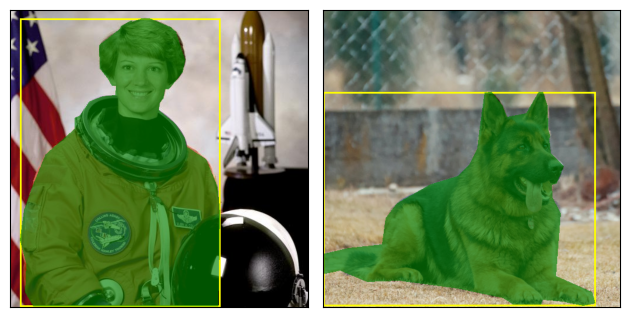

In [4]:
plot([dataset[0], dataset[1]])

## 变换

现在定义预处理变换。所有变换都知道如何在相关时处理图像、边界框和掩码。

变换通常作为数据集的 ``transforms`` 参数传递，以便它们可以利用 {class}`torch.utils.data.DataLoader` 的多进程处理。

In [5]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH, transforms=transforms)
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=["boxes", "labels", "masks"])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


这里有一些值得注意的地方：

- 将 {mod}`PIL` 图像转换为 {class}`~torchvision.transforms.v2.Image` 对象。这并不是严格必要的，但依赖于张量（这里是张量子类）[通常会更快](https://pytorch.org/vision/stable/transforms.html#transforms-perf)。
- 调用 {class}`~torchvision.transforms.v2.SanitizeBoundingBoxes` 来确保移除退化的边界框，以及它们对应的标签和掩码。{class}`~torchvision.transforms.v2.SanitizeBoundingBoxes` 应该至少在一个检测管道的末尾调用一次；如果使用了 {class}`~torchvision.transforms.v2.RandomIoUCrop`，这一点尤其关键。

看看样本在应用了增强管道后的样子：

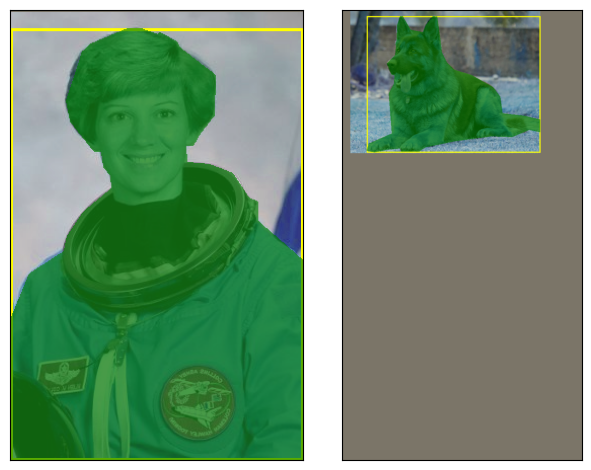

In [6]:
plot([dataset[0], dataset[1]])

可以看到图像的颜色被扭曲、放大或缩小，并且被翻转。边界框和掩码也相应地进行了变换。无需多言，可以开始训练了。

## 数据加载和训练循环

下面使用 Mask-RCNN，这是实例分割模型，但在本教程中涵盖的所有内容也适用于目标检测和语义分割任务。

In [7]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn=lambda batch: tuple(zip(*batch)),
)

model = models.get_model("maskrcnn_resnet50_fpn_v2", weights=None, weights_backbone=None).train()

for imgs, targets in data_loader:
    loss_dict = model(imgs, targets)
    # Put your training logic here

    print(f"{[img.shape for img in imgs] = }")
    print(f"{[type(target) for target in targets] = }")
    for name, loss_val in loss_dict.items():
        print(f"{name:<20}{loss_val:.3f}")

[img.shape for img in imgs] = [torch.Size([3, 512, 512]), torch.Size([3, 409, 493])]
[type(target) for target in targets] = [<class 'dict'>, <class 'dict'>]
loss_classifier     4.723
loss_box_reg        0.006
loss_mask           0.734
loss_objectness     0.691
loss_rpn_box_reg    0.036


## 训练参考

从那里，你可以查看[torchvision参考](https://github.com/pytorch/vision/tree/main/references)，在那里你将找到我们用来训练模型的实际训练脚本。

**免责声明** 我们参考资料中的代码比你自己使用案例所需的要复杂：这是因为我们支持不同的后端（PIL、张量、TVTensors）和不同的变换命名空间（v1和v2）。所以不要害怕简化并只保留你需要的部分。